# Part 3

With the components on the backwards stepping identified, we now want to undertsand how the sequential unfolding emerges.

## Part 3A
The first answer can be obtained by looking at information flow or graph cycling at the control level, which we illustrate here.

## Part 3B
We can complement this information using simulations of the neural network.

In [3]:
import os
import random

import imageio
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from vnc_networks import MANC, params
from vnc_networks.specific_neurons import (
    mdn_helper,
    motor_neurons_helper,
    sensory_neurons_helper,
)


In [4]:
# ----- Directories
manc_version = "v1.2"
MDN_DIR = "MDN_project"
FIG_DIR = MANC(manc_version).get_fig_dir()
MDN_FIGS = os.path.join(FIG_DIR, MDN_DIR)
os.makedirs(MDN_FIGS, exist_ok=True)

# Analysis choices
side = "RHS"
leg = "h"

# Save?
savefigs = False

# Part 3A: Graph at the premotor level

# Part 3Aa: Visualisation of the graph

We want to draw the graph including MDNs, important premotor neurons, motor neurons and sensory neurons.

In [5]:
CR = MANC(manc_version)
split_mdn_vnc = mdn_helper.get_vnc_split_MDNs_by_neuropil(
    not_connected=mdn_helper.get_mdn_bodyids()
)

Loaded VNC Connections object with MDNs split by neuropil.


In [6]:
# get the mdns
mdn_uids = mdn_helper.get_subdivided_mdns(
    split_mdn_vnc,
    neuropil=leg,
    # side=side,
)

In [7]:
# Get the key premotor neurons
premotor_df = pd.read_csv(
    os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_MDN_premotor_hubs.csv"),
)
pmn_bodyids = premotor_df["body_id"].values
pmn_uids = split_mdn_vnc.get_uids_from_bodyids(pmn_bodyids) # should match the "uid" column, but in case we change the connection loaded this is safer

In [8]:
# Hind leg, right side leg motor neurons
mn_uids = motor_neurons_helper.get_leg_motor_neurons(
    data=split_mdn_vnc,
    leg=leg,
    side=side,
)

In [9]:
# Hind leg, right side leg sensory neurons
sn_uids = sensory_neurons_helper.get_leg_sensory_neurons(
    data=split_mdn_vnc,
    leg=leg,
    side=side,
)

In [10]:
# Define the subgraph
all_nodes = set(pmn_uids)  #| set(mdn_uids)  #  | set(mn_uids)| set(sn_uids)
subgraph = split_mdn_vnc.subgraph(all_nodes)

Attribute class_1 not found in the graph. Adding it.


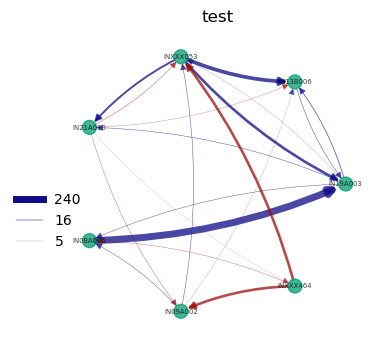

In [11]:
fig,ax = plt.subplots(figsize=(4,4))
ax = subgraph.display_graph(ax=ax, save=False, label_nodes=True, method="circular")

if savefigs:
    os.makedirs(os.path.join(MDN_FIGS, "tmp"), exist_ok=True)
    fig.savefig(
        os.path.join(MDN_FIGS, "tmp", f"MDN_premotor_{leg}_leg_{side}_subgraph.png"),
        bbox_inches="tight",
        dpi=300,
    )

plt.show()


The direct connections between the premotor neurons is coherent with the putative motor primitives that are controlled. Many of the connections are missing when looking only at direct paths, but the ones that exist either inhibit movements that are directly in opposition, or favour a transition from stance to swing.

# Part 3Ab: Graph random walk

Using update rules that are based on the graph, we can simulate the random walk of the graph. This will give us an idea of the information flow of the graph.

In [12]:
def scale_weights(graph, scale_factor):
    """
    Scale the weights of edges in the graph by a given factor.

    Parameters:
    - graph: NetworkX DiGraph, the input graph.
    - scale_factor: Factor to scale edge weights by.

    Returns:
    - A new graph with scaled edge weights.
    """
    new_graph = graph.copy()
    for u, v, data in new_graph.edges(data=True):
        data["weight"] *= scale_factor
    return new_graph


def initialize_activation_levels(graph):
    """
    Initialize activation levels for each node in the graph.

    Parameters:
    - graph: NetworkX DiGraph, the input graph.

    Returns:
    - A dictionary with nodes as keys and initial activation levels as values.
    """
    nb_nodes = len(graph.nodes())
    # generate a random number on a gaussian distribution centered around 1
    rnd = np.random.normal(1, 0.3, nb_nodes)
    return {node: rnd[i] / nb_nodes for i, node in enumerate(graph.nodes())}


def update_activation_levels(
    graph, activation_levels, decay_factor=0.9,
):
    """
    Stochastically update activation levels based on excitatory and inhibitory influences.

    Parameters:
    - graph: NetworkX DiGraph, the input graph.
    - activation_levels: Dictionary with current activation levels.
    - decay_factor: Factor to decay activation levels.
    - update_prob: Probability of updating each node.

    Returns:
    - Updated activation levels.
    """
    new_activation_levels = activation_levels.copy()

    for node in graph.nodes():
        total_influence = 0
        for neighbor in graph.predecessors(node):
            weight = graph[neighbor][node].get("weight", 1)
            total_influence += weight * activation_levels[neighbor]

        # Update activation level based on total influence and decay factor
        new_activation_levels[node] = max(
            0, (activation_levels[node] + total_influence )* decay_factor  
        )

    # Normalize activation levels
    total_activation = np.sum(list(new_activation_levels.values()))
    if total_activation > 0:
        new_activation_levels = {
            node: level / total_activation
            for node, level in new_activation_levels.items()
        }

    return new_activation_levels


def simulate_activation_spread(
    graph, steps, decay_factor=0.9, graph_scale_factor=1.0,
):
    """
    Simulate the stochastic spread of activation levels over time.

    Parameters:
    - graph: NetworkX DiGraph, the input graph.
    - steps: Number of simulation steps.
    - decay_factor: Factor to decay activation levels.
    - update_prob: Probability of updating each node.

    Returns:
    - Final activation levels after simulation.
    """
    scaled_graph = scale_weights(graph, graph_scale_factor)
    activation_levels = initialize_activation_levels(scaled_graph)
    activities = {node: [activation_levels[node]] for node in scaled_graph.nodes()}

    for _ in range(steps):
        activation_levels = update_activation_levels(
            scaled_graph, activation_levels, decay_factor
        )
        activities = {node: activities[node] + [activation_levels[node]] for node in graph.nodes()}

    return activities


In [13]:
# Relevant nodes for information flow
# hind leg motor neurons
mns = motor_neurons_helper.get_leg_motor_neurons(
    data=split_mdn_vnc,
    leg=leg,
)
# hind leg sensory neurons
sns = sensory_neurons_helper.get_leg_sensory_neurons(
    data=split_mdn_vnc,
    leg=leg,
)
# interneurons in the T3 neuropils
t3s = split_mdn_vnc.get_neuron_ids(
    {"neuropil":"T3"},
)

all_nodes = list(set(mdn_uids) | set(mns) | set(sns) | set(t3s))
graph = split_mdn_vnc.get_nx_graph(nodes=all_nodes)

In [14]:
# Find the avergae sum of weights coming into a node of the network
# We use that value to scale the weights of the edges

displayed_nodes = pmn_uids
incoming_weights = []
for node in pmn_uids:
    predecessors = graph.predecessors(node)
    # get all the weights of the edges from predecessors to node
    edges = [graph[pre][node].get("weight", 1) for pre in predecessors]
    incoming_weights.append(np.abs(np.sum(edges)))
print(f"Median incoming weight: {np.median(incoming_weights)}")
print(f"Average incoming weight: {np.mean(incoming_weights)}")


Median incoming weight: 1072.0
Average incoming weight: 981.5714285714286


In [15]:

# Simulate the stochastic spread of activation levels
steps = 150
nb_simulations = 10
decay_factor = 1
weight_scaling = 1 / np.mean(
    incoming_weights
) # 0.2 # translate the unknown scaling between weights and synapse count

multi_seed_final_activation_levels = {node: [] for node in graph.nodes()}

for i in range(nb_simulations):
    print(f"Simulation {i+1}/{nb_simulations}")
    final_activation_levels = simulate_activation_spread(
        graph, steps, decay_factor, weight_scaling
    )
    for node, levels in final_activation_levels.items():
        multi_seed_final_activation_levels[node].extend(levels)

displayed_nodes = pmn_uids

Simulation 1/10


KeyboardInterrupt: 

In [ ]:
# Show time series for displayed nodes
fig, ax = plt.subplots(figsize=(6,6))
for node in displayed_nodes:
    ax.plot(multi_seed_final_activation_levels[node], label=node)
ax.set_xlabel("Time")
ax.set_ylabel("Activation level")
ax.legend(loc="upper right")

if savefigs:
    fig.savefig(
        os.path.join(MDN_FIGS, "tmp", f"MDN_premotor_{leg}_leg_{side}_activation_time_series.png"),
        bbox_inches="tight",
        dpi=300,
    )

plt.show()

In [ ]:
# Find maximum time window to distinguish cross-correlation from auto-correlation
from scipy.signal import correlate

for node in displayed_nodes:
    corr = correlate(
        multi_seed_final_activation_levels[node],
        multi_seed_final_activation_levels[node],
    )
    corr = corr[len(corr) // 2 - steps // 2 : len(corr) // 2 + steps // 2]
    corr /= np.max(corr)
    lags = np.arange(-len(corr) // 2, len(corr) // 2)
    plt.plot(
        lags,
        corr,
        label=f"{node}",
    )
plt.legend()
plt.xlabel("Lag")
plt.ylabel("Cross-correlation")

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "tmp", f"MDN_premotor_{leg}_leg_{side}_cross_correlation.png"),
        bbox_inches="tight",
        dpi=300,
    )

plt.show()

In [ ]:
# Plot the relative cross-correlation between the nodes for one specific input
from scipy.signal import correlate

fig,ax = plt.subplots(figsize=(6,6))
node_a = pmn_uids[0]
for j, node_b in enumerate(pmn_uids):
    corr = correlate(
        multi_seed_final_activation_levels[node_a],
        multi_seed_final_activation_levels[node_b],
    )
    corr = corr[len(corr) // 2 - steps // 2 : len(corr) // 2 + steps // 2]
    corr /= np.max(corr)
    lags = np.arange(-len(corr) // 2, len(corr) // 2)
    ax.plot(
        lags,
        corr,
        label=f"{node_b}",
    )
    # Detect the max and show it as a dot
    max_idx = np.argmax(corr)
    ax.plot(lags[max_idx], corr[max_idx], "ro")
ax.legend()
ax.set_xlabel("Lag")
ax.set_ylabel("Cross-correlation")

if savefigs:
    fig.savefig(
        os.path.join(MDN_FIGS, "tmp", f"MDN_premotor_{leg}_leg_{side}_cross_correlation_relative.png"),
        bbox_inches="tight",
        dpi=300,
    )

plt.show()

There is a second peak in neuron self-cross-correlation at 25 steps. This means that all relevant mutual shifts should be analysed within that window.

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


# Define the colormap for negative values (blue to white)
colors_negative = [
    (1, 1, 1),  # White for large negative values
    (0, 0.4, 0.7),  # Bright blue for negative values close to 0
]

# Define the colormap for positive values (red to white)
colors_positive = [
    (0.6, 0.05, 0.04),  # Bright red for positive values close to 0
    (1, 1, 1),  # White for large positive values
]

# Create the colormaps
cmap_negative = LinearSegmentedColormap.from_list("cmap_negative", colors_negative)
cmap_positive = LinearSegmentedColormap.from_list("cmap_positive", colors_positive)

neg_entries = cmap_negative(np.linspace(0, 1, 128))[:-1]
black_entry = np.array([(0, 0, 0, 1), (0, 0, 0, 1)])
pos_entries = cmap_positive(np.linspace(0, 1, 128))[1:]
# Concatenate the colormaps in one colormap, not stacking but flattening
colors_combined = np.concatenate([neg_entries, black_entry, pos_entries], axis=0)

# Create the combined colormap
custom_cmap = ListedColormap(colors_combined)

In [ ]:
# Estimate the phase lag between the displayed neurons
from scipy.signal import correlate
from scipy.stats import pearsonr


visualised_nodes = [7024,11907, 21924,9595,19455,15581,9431]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Identify the lags
lag_matrix = np.zeros((len(visualised_nodes), len(visualised_nodes)))
for i, nodeA in enumerate(visualised_nodes):
    for j, nodeB in enumerate(visualised_nodes):
        corr = correlate(
            multi_seed_final_activation_levels[nodeA],
            multi_seed_final_activation_levels[nodeB],
        )
        corr = corr[len(corr) // 2 - steps // 2 : len(corr) // 2 + steps // 2]
        corr /= np.max(corr)
        lags = np.arange(-len(corr) // 2, len(corr) // 2)
        # detect where the max occurs
        max_idx = np.argmax(corr)
        max_lag = lags[max_idx]
        lag_matrix[i, j] = max_lag

maximum_lag = np.max(np.abs(lag_matrix))
im0 = axs[0].matshow(
    lag_matrix, cmap=custom_cmap, vmin=-1 * maximum_lag, vmax=maximum_lag
)
# label the axes with the neuron names
axs[0].set_xticks(
    range(len(visualised_nodes)), [str(n) for n in visualised_nodes], rotation=90
)
axs[0].set_yticks(range(len(visualised_nodes)), [str(n) for n in visualised_nodes])
# add colorbar
cbar = plt.colorbar(im0)
cbar.set_label("Lag (time steps)")

# Shift the activation levels to account for the phase lag
corr = np.zeros((len(visualised_nodes), len(visualised_nodes)))
for i, nodeA in enumerate(visualised_nodes):
    shifted_activation_levels = multi_seed_final_activation_levels.copy()
    for j, nodeB in enumerate(visualised_nodes):
        if i != j:
            shift = int(lag_matrix[i, j])
            shifted_activation_levels[nodeB] = np.roll(
                multi_seed_final_activation_levels[nodeB], shift
            )
        # compute the cross-correlation
        corr[i, j], _ = pearsonr(
            multi_seed_final_activation_levels[nodeA], shifted_activation_levels[nodeB]
        )
im2 = axs[1].matshow(corr, cmap=params.grey_heatmap, vmin=-1, vmax=1)
# label the axes with the neuron names
axs[1].set_xticks(
    range(len(visualised_nodes)), [str(n) for n in visualised_nodes], rotation=90
)
axs[1].set_yticks(range(len(visualised_nodes)), [str(n) for n in visualised_nodes])
# add colorbar
cbar = plt.colorbar(im2)
cbar.set_label("Correlation coefficient lag corrected")

plt.tight_layout()

if savefigs:
    fig.savefig(
        os.path.join(MDN_FIGS, "tmp", f"MDN_premotor_{leg}_leg_{side}_lag_matrix.png"),
        bbox_inches="tight",
        dpi=300,
    )

plt.show()

In [ ]:
pmn_sorted = split_mdn_vnc.list_neuron_properties(visualised_nodes)
pmn_sorted


In [ ]:
def make_video_of_activation_specific_nodes(
        graph: nx.DiGraph, # the graph
        pos: dict, # positions of the nodes of interest
        activation_levels: dict[int: list[float]], # activation levels of the nodes of interest
):
        """ 
        Create an image for each of the time steps (number of steps in activation_levels).
        The image shows the activation levels of the nodes of interest as colours on the
        nodes of the graph, visualised as circles.
        A colour bar shows the mapping between activation level and colour.
        """
        # Create a colour map where the max value corresponds to the top colour
        cmap = plt.cm.get_cmap(params.red_heatmap)
        max_value = max([max(activation_levels[node][1:]) for node in pos.keys()])
        norm = plt.Normalize(vmin=0, vmax=max_value)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

        # Create subgraph with only the nodes of interest
        subgraph = graph.subgraph(pos.keys())

        # Identify the number of time steps
        num_steps = len(activation_levels[list(activation_levels.keys())[0]])

        # create a directory to save the images
        os.makedirs(os.path.join(MDN_FIGS,"tmp","frames"), exist_ok=True)

        # Draw the nodes
        for step in range(1, num_steps):
            # Create a dictionary of node colours according to the map defined above
            node_colors = {
                node: cmap(norm(activation_levels[node][step])) for node in activation_levels.keys()
            }

            # Create a figure and axis
            fig, ax = plt.subplots(figsize=(4,4))
            ax.set_aspect("equal", adjustable="datalim")

            # Draw the nodes
            nx.draw_networkx_nodes(
                subgraph,
                pos=pos,
                node_color=[node_colors[node] for node in subgraph.nodes()],
                ax=ax,
            )

            # Add a color bar
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Activation level")

            # Save the image
            fig.savefig(
                os.path.join(MDN_FIGS, "tmp", "frames", f"frame_{step:03d}.png"),
                bbox_inches="tight",
                dpi=300,
            )

            # Close the figure
            plt.close(fig)
            del fig, ax


        # Create a video from the saved frames
        video_path = os.path.join(MDN_FIGS, "tmp", "videos")
        os.makedirs(video_path, exist_ok=True)
        path = os.path.join(video_path, "activation_spread.mp4")

        with imageio.get_writer(path, fps=15) as writer:
            for i in range(1, num_steps):
                frame_filename = f'frame_{i:03d}.png'
                frame_dir = os.path.join(MDN_FIGS, "tmp", "frames", frame_filename)
                writer.append_data(imageio.imread(frame_dir))
                os.remove(
                    frame_dir
                )  # Optionally remove the frame file after adding it to the video

        print("Video creation complete.")

        return

In [ ]:
"""

focus_nodes = pmn_uids
display_graph = graph.subgraph(focus_nodes)
pos = nx.circular_layout(display_graph)

make_video_of_activation_specific_nodes(
    graph=graph,
    pos=pos,
    activation_levels=multi_seed_final_activation_levels,
)
"""